In [19]:
import numpy as np
import datetime 
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading 
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import yfinance as yf

Define Functions

In [20]:
# Get historical data for a given ticker
def get_data_features(ticker, start_date, end_date, interval='1h'):
    data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval=interval)
    # Clean data by removing NaN values
    data.dropna(inplace=True)
    return data


Define Ticker and Time Range

In [21]:
ticker = 'AAPL'
# start_date = datetime.datetime(2019, 1, 1)
# end_date = datetime.datetime(2020, 1, 1)

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=59)

df = get_data_features(ticker, start_date, end_date)

len(df)

272

Create Trading Environment

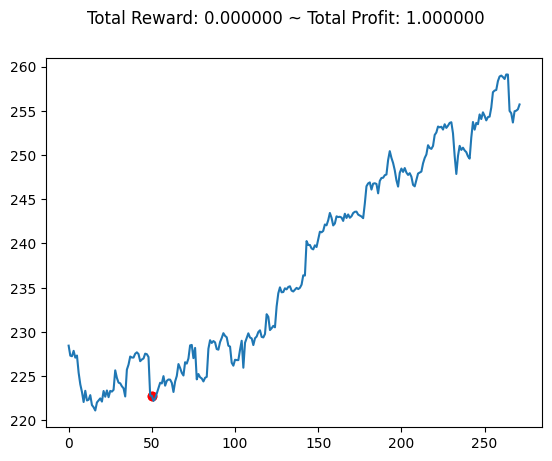

KeyboardInterrupt: 

In [22]:
# Window size: the number of historical data used for prediction
window_size = 50

# Frame bound: the range of historical data used for training
frame_bound = (50, 900)

# Create the trading environment using the given historical data and frame bound
environment = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=frame_bound
)

environment.reset()
environment.render()
environment.action_space

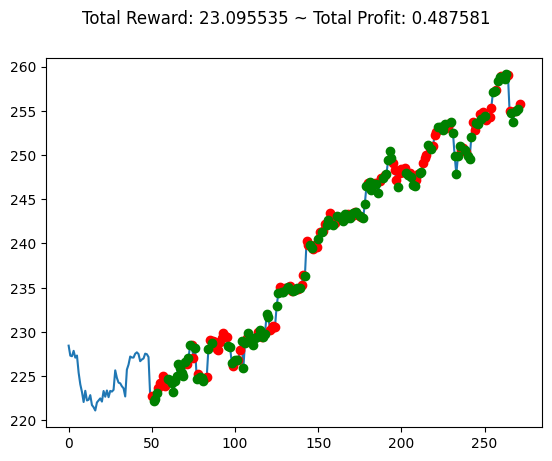

In [13]:
observation, info = environment.reset()

# Run a single episode until it ends with random actions
done = False
while not done:
    action = environment.action_space.sample()

    observation, reward, terminated, truncated, info = environment.step(action)
    done = terminated or truncated

# Render the environment and actions after the episode ends    
plt.cla()
environment.unwrapped.render_all()
plt.show()

environment.close()

In [14]:
# For model
environment = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=frame_bound
)


Build the Model and Train

In [15]:

model = PPO('MlpPolicy', environment, verbose=0)

model.learn(total_timesteps=1_000_000, progress_bar=True)


Output()

Set up Test Environment

In [17]:
frame_bound = (50, 272)

environment = gym.make(
    'stocks-v0', 
    df=df, 
    window_size=window_size, 
    frame_bound=frame_bound
)

observation, info = environment.reset()

done = False
while not done:
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = environment.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break




info {'total_reward': 24.919692993164062, 'total_profit': 0.6395779881827315, 'position': <Positions.Long: 1>}


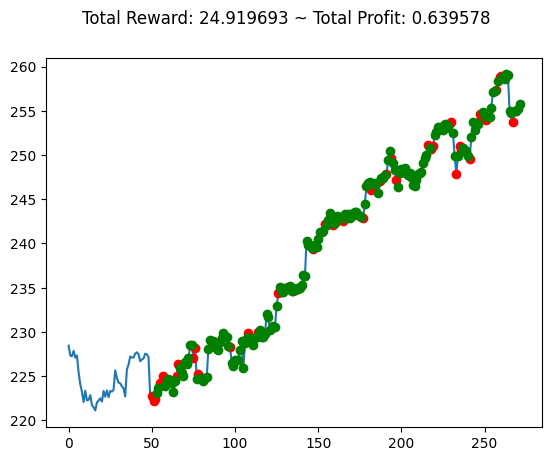

In [18]:
plt.cla()
environment.unwrapped.render_all()
plt.show()

In [23]:
model.save("ppo_model")